# Neighborhood Similarity vs. Euclidean Distance
## 0. Loading Data, Building KNN-Graph

We have removed the first class.


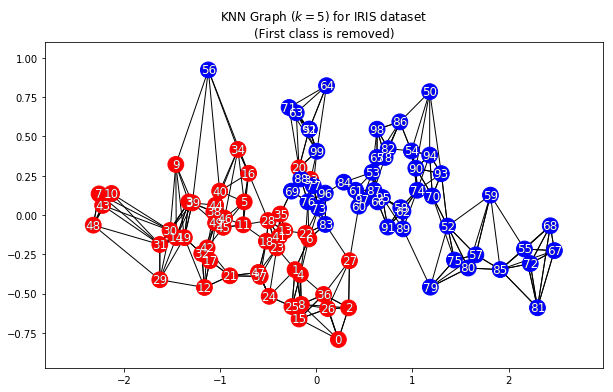

4.7921852443
1.71465343207


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# -------------------- #
# Loading IRIS dataset #
# -------------------- #
remove_first_class = True #@param ["True", "False"] {type: "raw"}

D, l = datasets.load_iris(return_X_y=True)

if remove_first_class:
    D = D[50:,:]
    l = l[50:]
    colors = {1: 'r', 2: 'b'}
    labels = [1, 2]
    print('We have removed the first class.')
else:
    colors = ['r', 'g', 'b']
    labels = [0, 1, 2]

D = PCA(n_components = 2).fit_transform(D)
# for col in range(D.shape[1]):
#     D[:,col] = (D[:,col] - D[:,col].min()) / (D[:,col].max() - D[:,col].min())

# ------------------ #
# Creating the graph #
# ------------------ #
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph
k_neighbors = 5 #@param {type: "integer"}

# Getting adjacency matrix
A = kneighbors_graph(D, k_neighbors)

# Putting EuclideanDistance as graph weight
rows, cols = A.nonzero()
for i in range(len(rows)):
  A[rows[i],cols[i]] = float(LA.norm(D[rows[i],:] - D[cols[i],:]))

# Putting datapoint labels as "class" attribute on nodes
G = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())
for v in G.node:
    for u in G[v]:
        G[v][u]['weight'] = float(G[v][u]['weight'])

node_label = {}
for v in G.node.keys():
    node_label[v] = str(l[v])
# nx.set_node_attributes(G, 'class', node_label)

# Putting 2D position of each node on it for Graph layout
pos = {}
for i in range(D.shape[0]):
    G.node[i]['x'] = float(D[i,0])
    G.node[i]['y'] = float(D[i,1])
    pos[i] = (float(D[i,0]), float(D[i,1]))

node_color = ['red'] * 50 + ['blue'] * 50
plt.figure(figsize=(10, 6))
nx.draw_networkx(G, pos=pos, node_color=node_color, node_size=250, arrows=False)
nx.draw_networkx_labels(G, pos, font_color='white')

plt.title('KNN Graph ($k = 5$) for IRIS dataset\n(First class is removed)')
plt.show()

print(D[:,0].max() - D[:,0].min())
print(D[:,1].max() - D[:,1].min())

## 1. Neighborhood Similarity Functions

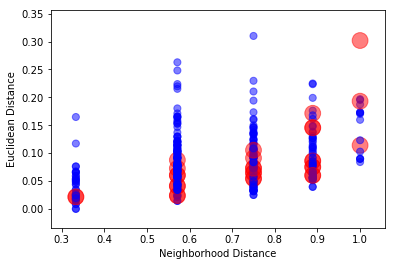

In [116]:
from sklearn.preprocessing import normalize

def neighborhood_distance(G, v, u):
    
    v_neighbors = set(nx.neighbors(G, v))
    u_neighbors = set(nx.neighbors(G, u))
    
    sim = float(len(v_neighbors & u_neighbors)) / len(u_neighbors | v_neighbors)
    
    return 1.0 - sim

nei_dis = []
euc_dis = []
cls_sim = []
edges = []

alphas = []
sizes = []

for (v,u) in G.edges_iter():
    if l[v] == l[u]:
        cls_sim.append('blue')
        alphas.append(.1)
        sizes.append(50)
    else:
        cls_sim.append('red')
        alphas.append(.75)
        sizes.append(250)
    nei_dis.append(neighborhood_distance(G, v, u))
    euc_dis.append(LA.norm(D[v,:] - D[u,:]))
    edges.append((v,u))

nei_dis = np.array(nei_dis)
euc_dis = np.array(euc_dis)

marker_size = 100
plt.scatter(
    nei_dis, # Neighborhood distance
    euc_dis, # Euclidean distance
    c = cls_sim, # Colors are based on class similarity
    s = sizes,
    alpha = .5
)

plt.xlabel('Neighborhood Distance')
plt.ylabel('Euclidean Distance')

border = 0.05

plt.show();

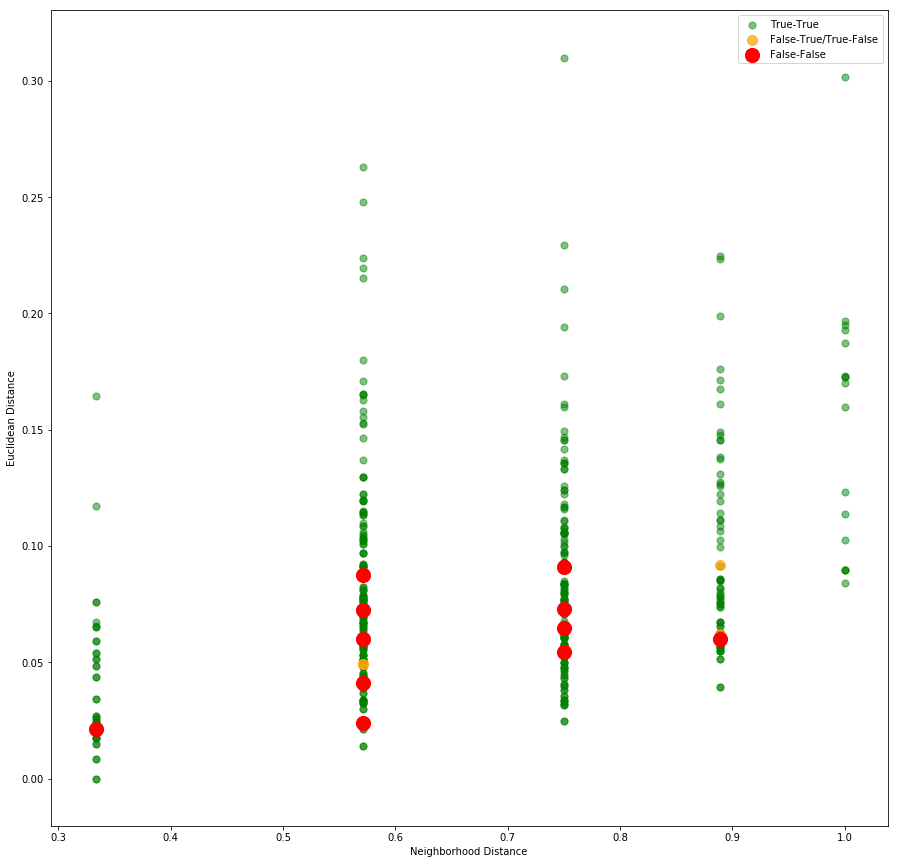

#TT = 485
#FT/TF = 4
#FF = 11


In [117]:
from sklearn.neighbors import KNeighborsClassifier

# Training classifiers
knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier.fit(D, l)

l_pred = knn_classifier.predict(D)

edge_pred_success = []
for v, u in edges:
    if (l_pred[v] == l[v]):
        edge_pred_success.append(1.0)
    elif (l[v] == l[u]): # This is a same-class link, but not strong enough
        edge_pred_success.append(.5)
    else: # U is one of the reasons V is misclassified
        edge_pred_success.append(0.0)
#     v_pred_success = int(l_pred[v] == l[v])
#     u_pred_success = int(l_pred[u] == l[u])    
#     edge_pred_success.append(float(v_pred_success + u_pred_success) / 2)
edge_pred_success = np.array(edge_pred_success)

# Plotting
marker_size = 100

plt.figure(num=None, figsize=(15, 15))
plt.scatter(
    nei_dis[edge_pred_success == 1.0],
    euc_dis[edge_pred_success == 1.0],
    c='green',
    s=marker_size / 2,
    alpha=.5,
    label = 'True-True'
)

plt.scatter(
    nei_dis[edge_pred_success == .5],
    euc_dis[edge_pred_success == .5],
    c='orange',
    s=marker_size,
    alpha=.75,
    label = 'False-True/True-False'
)

plt.scatter(
    nei_dis[edge_pred_success == 0.0],
    euc_dis[edge_pred_success == 0.0],
    c='red',
    s=marker_size*2,
    label = 'False-False'
)

plt.xlabel('Neighborhood Distance')
plt.ylabel('Euclidean Distance')

plt.legend()
plt.show();

print('#TT = ' + str(sum(edge_pred_success == 1.0)))
print('#FT/TF = ' + str(sum(edge_pred_success == .5)))
print('#FF = ' + str(sum(edge_pred_success == 0.0)))

# edges = np.array(edges)
# print(edges[edge_pred_success == 0.0])

In [120]:
#@title Creating a graph with colored edges based on TT, FT/TF, FF
plt.figure(num=None, figsize=(20,20))

edge_color_array = []
edge_colors = {}
for idx, edge in enumerate(edges):
    if edge_pred_success[idx] == 1.0:
        edge_colors[tuple(edge)] = 'green'
    elif edge_pred_success[idx] == .5:
        edge_colors[tuple(edge)] = 'orange'
    else:
        edge_colors[tuple(edge)] = 'red'
    edge_color_array.append(edge_colors[tuple(edge)])
# tmp_colors = range(len(edges))
# nx.set_edge_attributes(G, 'edgePredictionSuccess', edge_colors)

# nx.write_gml(G, 'knn_neighborhood_distance_euclidean_distance.gml')
# nx.write_graphml(G, 'nei_euc.graphml')



# print('#FT/TF = ' + str(sum(edge_pred_success == .5)))
# print(edges[np.where(edge_pred_success == 0.5)])
# print(G[1][6])

# print(G[0])

# nx.draw_networkx(
#     G, pos,
#     node_color=node_color,
#     edge_color=edge_colors,
#     width=5,
#     edge_cmap=plt.cm.plasma,
#     node_size=750,
#     arrows=False,
#     font_color='white',
#     font_weight='bold'
# )

# plt.show();

In [124]:

plt.gcf().clear();
f, (left, right) = plt.subplots(1, 2, figsize=(20,10));

drawn_nodes = nx.draw_networkx_nodes(
    G, pos, ax=left,
    node_size=125,
    node_color=node_color,
    alpha=.5
);

drawn_nodes.set_edgecolor('black')
drawn_nodes.set_lw(1)

print(np.where(edge_pred_success == .5))
nx.draw_networkx_edges(
    G, pos, ax=left,
    edgelist=[tuple(x) for x in edges[np.where(edge_pred_success == .5)]],
    edge_color='orange',
    width=2
);
nx.draw_networkx_edges(
    G, pos, ax=left,
    edgelist=[tuple(x) for x in edges[np.where(edge_pred_success == 1.0)]],
    edge_color='green',
    width=1,
    alpha=.25
);


# Right figure, only both falsely classified
drawn_nodes = nx.draw_networkx_nodes(
    G, pos, ax=right,
    node_size=125,
    node_color=node_color,
    alpha=.5
);

drawn_nodes.set_edgecolor('black');
drawn_nodes.set_lw(1);

nx.draw_networkx_edges(
    G, pos, ax=right,
    edgelist=[tuple(x) for x in edges[np.where(edge_pred_success == 0)]],
    edge_color='red',
    width=2
);

nx.draw_networkx_edges(
    G, pos, ax=right,
    edgelist=[tuple(x) for x in edges[np.where(edge_pred_success == 1.0)]],
    edge_color='green',
    width=1,
    alpha=.25
);

# print([tuple(x) for x in edges[np.where(edge_pred_success == 0)]])
print(D[56,:])
print(G)

plt.show();

(array([101, 167, 416, 419], dtype=int64),)


TypeError: list indices must be integers or slices, not tuple

In [94]:
#Testing adamic adar vs. euclidean distance
def ada(G, v, u):
    

for v,u in G.edges_iter():
    

0 26
